## Suitability analysis for house rentals in Boston
### Eliza Vardanyan
### UEP 239: Geospatial Programming Python 


The project aims to identify the most suitable area for a family of four (comprising parents and two kids) seeking a rental apartment in the City of Boston. The project's key indicators include the availability and quality of public schools and hospitals, crime rates, housing prices, number of bedrooms, and location, particularly the distance to the downtown area. I came up with this project idea based on my personal experience of helping a friend with a family of four who is considering moving to Boston. By analyzing the data by Zip Code, we hope to determine the areas that are most conducive to their needs.

***

### 1. Import of necessary packages and modules

To start off, we first download all the packages and modules that we plan on using in the code. 

In [1]:
# !conda install -c conda-forge basemap
# imports

# import necessary libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
import requests
import json
from zipfile import ZipFile
# from mpl_toolkits.basemap import Basemap
import math
import folium
# import squarify
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.cm import viridis
from folium.plugins import HeatMap
from matplotlib.colors import Normalize
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import MinMaxScaler
import contextily as ctx
from shapely.geometry import Point



!pip install pyproj
# !pip install folium==0.10.1
import pyproj
# -- updating matplotlib library 
!pip install --upgrade matplotlib





### 1.1. Note about MPO boundary: 

For the suitability analysis, I have chosen the city of Boston as my area of focus. Although MPO boundaries could have been utilized in my analysis, I have opted to use other indicators such as schools, crime rates, hospitals, apartment rates, number of bedrooms, and apartment location. 

***

### 2. Reading Hospital Data


To gather hospital data, I accessed the City of Boston's Open Data Hub, which provided information on the hospitals in the city, including their names and locations. The link to this information can be found here: https://data.boston.gov/dataset/hospital-locations

Note that the data was provided as a URL for a text file, which required me to use a script to download and save the data as a CSV file. The script, which can be found in the directory under 'hospital_data_retrieve.py', successfully retrieved the hospital data, and it is now available in the same directory as 'hospital-locations.csv'.

In [2]:
df_hospital = pd.read_csv('hospital-locations.csv')


To see what the data looks like, we display the first 4 rows of the data. 

In [3]:
df_hospital.head(4)

NAME                  AD  ZIPCODE  \
0                       Lemuel Shattuck Hospital       170 MORTON ST     2130   
1  Beth Israel Deaconess Medical Center East Cam    330 BROOKLINE AV     2115   
2                       Jewish Memorial Hospital      59 TOWNSEND ST     2119   
3                   New England Baptist Hospital  125 PARKER HILL AV     2120   

            NEIGH      XCOORD      YCOORD  \
0      ROSLINDALE  71106033.0  42300022.0   
1  FENWAY/KENMORE  71106780.0  42339726.0   
2         ROXBURY  71092712.0  42318569.0   
3   JAMAICA PLAIN  71107615.0  42329944.0   

                                            Location  
0  170 MORTON STROSLINDALE, MA 02130(42.300250008...  
1  330 BROOKLINE AVFENWAY/KENMORE, MA 02115(42.34...  
2  59 TOWNSEND STROXBURY, MA 02119(42.31856289432...  
3  125 PARKER HILL AVJAMAICA PLAIN, MA 02120(42.3...

In the above cell, I noticed that the 'Location' data was the full address combined with 'Latitude' and 'Longitude'. To avoid any future errors, I decided to split these into separate columns.

### 2.1 Processing & cleaning the data

In [4]:
# extracting the full address and (latitude-longitude) values from the 'Location' column
df_hospital[['Address', 'LatLong']] = df_hospital['Location'].str.split('(', 1, expand=True)

# extract the latitude and longitude values from the 'LatLong' column
df_hospital[['Latitude', 'Longitude']] = df_hospital['LatLong'].str.extract(r'(.+), (.+)\)', expand=True)

# Now that we split it, we do not need the Location adn LatLong columns and we can drop
# the 'Location' and 'LatLong' columns

df_hospital.drop(['Location', 'LatLong'], axis=1, inplace=True)

# print the first five rows of the updated dataframe
df_hospital.head(4)

/var/folders/s1/534byrbj2dzd4fltzk4wf9cc0000gn/T/ipykernel_12325/2965490432.py:2: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df_hospital[['Address', 'LatLong']] = df_hospital['Location'].str.split('(', 1, expand=True)


NAME                  AD  ZIPCODE  \
0                       Lemuel Shattuck Hospital       170 MORTON ST     2130   
1  Beth Israel Deaconess Medical Center East Cam    330 BROOKLINE AV     2115   
2                       Jewish Memorial Hospital      59 TOWNSEND ST     2119   
3                   New England Baptist Hospital  125 PARKER HILL AV     2120   

            NEIGH      XCOORD      YCOORD  \
0      ROSLINDALE  71106033.0  42300022.0   
1  FENWAY/KENMORE  71106780.0  42339726.0   
2         ROXBURY  71092712.0  42318569.0   
3   JAMAICA PLAIN  71107615.0  42329944.0   

                                     Address            Latitude  \
0          170 MORTON STROSLINDALE, MA 02130   42.30025000839615   
1   330 BROOKLINE AVFENWAY/KENMORE, MA 02115    42.3438499996779   
2            59 TOWNSEND STROXBURY, MA 02119   42.31856289432221   
3  125 PARKER HILL AVJAMAICA PLAIN, MA 02120  42.329611374844326   

            Longitude  
0  -71.10737910445549  
1  -71.08983000035408  
2  -71.09165569529381  
3  -71.10616871232227

### 2.2 Reclassifying the hospital data

To classify the hospitals, I have chosen to use the neighborhoods as an indicator. The scoring system is based on the location, proximity to the city center, and hospital services provided by the hospitals. Hospitals with specific names are assigned varying scores based on their reputation, size, and other factors. Initially, I created a function to facilitate the reclassification of my dataframe.

In [5]:
def classify_hospital(row):
    score = 0
    # If the hospital is in Roslindale or Jamaica Plain (South), add 1 point to the score
    if row['NEIGH'] in ['ROSLINDALE', 'JAMAICA PLAIN']:
        score += 1
    # If the hospital is in Fenway/Kenmore or Roxbury (Central), add 2 points to the score
    elif row['NEIGH'] in ['FENWAY/KENMORE', 'ROXBURY']:
        score += 2
    # If the hospital is in Downtown or Back Bay (Central), add 3 points to the score
    elif row['NEIGH'] in ['DOWNTOWN', 'BACK BAY']:
        score += 3
    # If the hospital is in South Boston, add 4 points to the score
    elif row['NEIGH'] == 'SOUTH BOSTON':
        score += 4
    # If the hospital is in Charlestown or West End (North), add 5 points to the score
    elif row['NEIGH'] in ['CHARLESTOWN', 'WEST END']:
        score += 5
    # If the hospital is in the Longwood Medical Area (Central), add 6 points to the score
    elif row['NEIGH'] == 'LONGWOOD MEDICAL AREA':
        score += 6
    # If the hospital is in any other neighborhood, add 0 points to the score
    else:
        score += 0
        
    # If the hospital is Beth Israel Deaconess Medical Center or Brigham and Women's Hospital, add 1 point to the score
    if row['NAME'] in ['Beth Israel Deaconess Medical Center', 'Brigham and Women\'s Hospital']:
        score += 1
    # If the hospital is Massachusetts General Hospital or Boston Medical Center, add 2 points to the score
    elif row['NAME'] in ['Massachusetts General Hospital', 'Boston Medical Center']:
        score += 2
    # If the hospital is Tufts Medical Center or New England Baptist Hospital, add 3 points to the score
    elif row['NAME'] in ['Tufts Medical Center', 'New England Baptist Hospital']:
        score += 3
    # If the hospital is any other hospital, add 0 points to the score
    else:
        score += 1
        
    return score


In [6]:
df_hospital['total_score'] = df_hospital.apply(classify_hospital, axis=1)

In [7]:
df_hospital.head(4)

NAME                  AD  ZIPCODE  \
0                       Lemuel Shattuck Hospital       170 MORTON ST     2130   
1  Beth Israel Deaconess Medical Center East Cam    330 BROOKLINE AV     2115   
2                       Jewish Memorial Hospital      59 TOWNSEND ST     2119   
3                   New England Baptist Hospital  125 PARKER HILL AV     2120   

            NEIGH      XCOORD      YCOORD  \
0      ROSLINDALE  71106033.0  42300022.0   
1  FENWAY/KENMORE  71106780.0  42339726.0   
2         ROXBURY  71092712.0  42318569.0   
3   JAMAICA PLAIN  71107615.0  42329944.0   

                                     Address            Latitude  \
0          170 MORTON STROSLINDALE, MA 02130   42.30025000839615   
1   330 BROOKLINE AVFENWAY/KENMORE, MA 02115    42.3438499996779   
2            59 TOWNSEND STROXBURY, MA 02119   42.31856289432221   
3  125 PARKER HILL AVJAMAICA PLAIN, MA 02120  42.329611374844326   

            Longitude  total_score  
0  -71.10737910445549            2  
1  -71.08983000035408            3  
2  -71.09165569529381            3  
3  -71.10616871232227            4

### 2.3 Visualizing hospital score data

I also obtained the ZCTA geojson file from the Census Bureau and have read it into zipcodes geodataframe. 

In [8]:
# load the zip code shapefile for Boston city
zipcodes = gpd.read_file("ZIP_Codes.geojson")

In [9]:
zipcodes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   OBJECTID       43 non-null     int64   
 1   ZIP5           43 non-null     object  
 2   ShapeSTArea    43 non-null     float64 
 3   ShapeSTLength  43 non-null     float64 
 4   geometry       43 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(1)
memory usage: 1.8+ KB


In [10]:
#I convert the ZIP5 of the zipcodes geodataframe to be able to merge this with my hospitals dataframe
zipcodes['ZIP5'] = zipcodes['ZIP5'].astype(int)


I then group the hospitals data by zipcode and keep the columns ZIPCODE, NEIGH (Neighborhood), and find the total score for that zip code. 

In [11]:
score_by_zip = df_hospital.groupby(['ZIPCODE', 'NEIGH'])['total_score'].mean().reset_index()

In [12]:
score_by_zip.head()

ZIPCODE           NEIGH  total_score
0     2111         CENTRAL         1.00
1     2114         CENTRAL         1.25
2     2115  FENWAY/KENMORE         3.00
3     2118       SOUTH END         1.50
4     2119         ROXBURY         3.00

To avoid any NaN values in the Total Score, I fill those with a value of '0' since that is the lowest score and it would not impact the scoring in any way.

In [13]:
score_by_zip['total_score'] = score_by_zip['total_score'].fillna(0)


Now that we have our hospitals dataframe reclassified, we can plot it by the zipcodes, where the darker shades correspond to the higher hospital score thus a more preferable place to find housing and vice versa. 

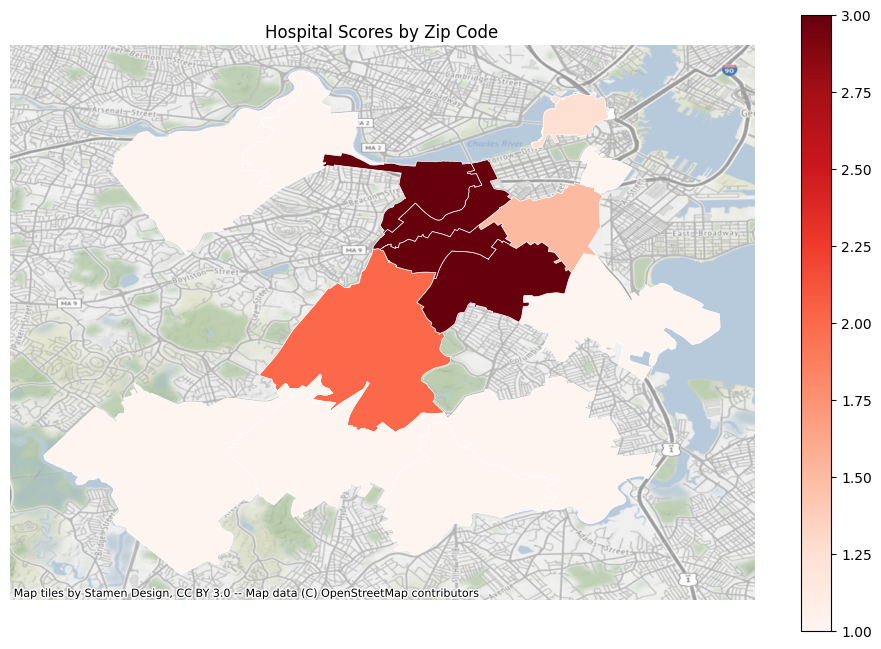

In [14]:
data_zip_hospital = zipcodes.merge(score_by_zip, left_on='ZIP5', right_on='ZIPCODE', how='left')

fig, ax = plt.subplots(figsize=(12, 8))
data_zip_hospital.plot(column='total_score',
                       cmap='Reds', 
                       linewidth=0.5, 
                       edgecolor='white',
                       legend=True, ax=ax)

ax.set_title('Hospital Scores by Zip Code')
ax.set_axis_off()
ctx.add_basemap(ax, crs = zipcodes.crs, alpha = 0.7)
plt.show()

To take this a step further and identify which neighborhoods correspond to the zip codes, I also displayed the same map with the neighborhood names overlaid on top of the map.

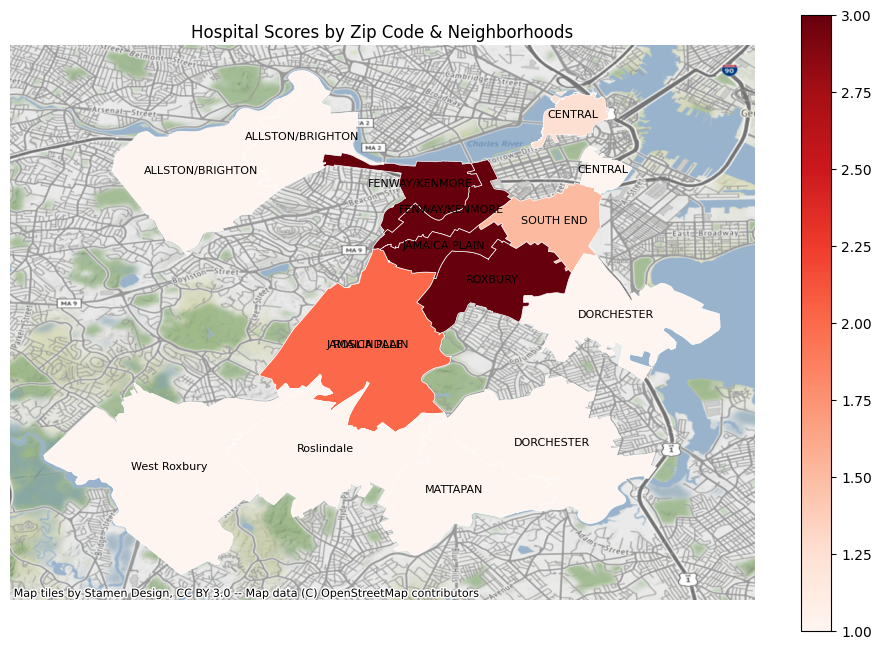

In [15]:
data_zip_hospital = zipcodes.merge(score_by_zip, left_on='ZIP5', right_on='ZIPCODE', how='left')

fig, ax = plt.subplots(figsize=(12, 8))
data_zip_hospital.plot(column='total_score',
                       cmap='Reds', 
                       linewidth=0.5, 
                       edgecolor='white',
                       legend=True, ax=ax)
for idx, row in data_zip_hospital.iterrows():
    if not np.isnan(row['total_score']):
        ax.text(row.geometry.centroid.x, row.geometry.centroid.y, s=row['NEIGH'], 
                horizontalalignment='center', fontsize=8)
ax.set_title('Hospital Scores by Zip Code & Neighborhoods')
ax.set_axis_off()
ctx.add_basemap(ax, crs = data_zip_hospital.crs)


plt.show()


***

### 3.1 Reading the Crime Data

The second indicator I selected was crime data, which I obtained from Kaggle. This dataset included Boston's Open Data Hub's 2018 crime data in both offense code and crime incident report formats. The data can be found at this link: https://www.kaggle.com/datasets/AnalyzeBoston/crimes-in-boston. When reading the data, I specified the encoding of the document as the file may have contained characters that the default encoding (UTF-8) could not read. The specified encoding (ISO-8859-1) is capable of handling a wider range of characters.

In [16]:
crime_data = pd.read_csv('Boston_crime_data/crime.csv', encoding='ISO-8859-1')

In [17]:
crime_data.head(5)

INCIDENT_NUMBER  OFFENSE_CODE    OFFENSE_CODE_GROUP   OFFENSE_DESCRIPTION  \
0      I182070945           619               Larceny    LARCENY ALL OTHERS   
1      I182070943          1402             Vandalism             VANDALISM   
2      I182070941          3410                 Towed   TOWED MOTOR VEHICLE   
3      I182070940          3114  Investigate Property  INVESTIGATE PROPERTY   
4      I182070938          3114  Investigate Property  INVESTIGATE PROPERTY   

  DISTRICT REPORTING_AREA SHOOTING     OCCURRED_ON_DATE  YEAR  MONTH  \
0      D14            808      NaN  2018-09-02 13:00:00  2018      9   
1      C11            347      NaN  2018-08-21 00:00:00  2018      8   
2       D4            151      NaN  2018-09-03 19:27:00  2018      9   
3       D4            272      NaN  2018-09-03 21:16:00  2018      9   
4       B3            421      NaN  2018-09-03 21:05:00  2018      9   

  DAY_OF_WEEK  HOUR    UCR_PART       STREET        Lat       Long  \
0      Sunday    13    Part One   LINCOLN ST  42.357791 -71.139371   
1     Tuesday     0    Part Two     HECLA ST  42.306821 -71.060300   
2      Monday    19  Part Three  CAZENOVE ST  42.346589 -71.072429   
3      Monday    21  Part Three   NEWCOMB ST  42.334182 -71.078664   
4      Monday    21  Part Three     DELHI ST  42.275365 -71.090361   

                      Location  
0  (42.35779134, -71.13937053)  
1  (42.30682138, -71.06030035)  
2  (42.34658879, -71.07242943)  
3  (42.33418175, -71.07866441)  
4  (42.27536542, -71.09036101)

I then converted the Latitude and Longitude columns' data types to 'float' since in the later stage where I needed to use these, I wanted to ensure these are in the correct data type. 

In [18]:
crime_data['Lat'] = crime_data['Lat'].astype(float)
crime_data['Long'] = crime_data['Long'].astype(float)

In [19]:
crime_data.head(2)

INCIDENT_NUMBER  OFFENSE_CODE OFFENSE_CODE_GROUP OFFENSE_DESCRIPTION  \
0      I182070945           619            Larceny  LARCENY ALL OTHERS   
1      I182070943          1402          Vandalism           VANDALISM   

  DISTRICT REPORTING_AREA SHOOTING     OCCURRED_ON_DATE  YEAR  MONTH  \
0      D14            808      NaN  2018-09-02 13:00:00  2018      9   
1      C11            347      NaN  2018-08-21 00:00:00  2018      8   

  DAY_OF_WEEK  HOUR  UCR_PART      STREET        Lat       Long  \
0      Sunday    13  Part One  LINCOLN ST  42.357791 -71.139371   
1     Tuesday     0  Part Two    HECLA ST  42.306821 -71.060300   

                      Location  
0  (42.35779134, -71.13937053)  
1  (42.30682138, -71.06030035)

We then convert our crime dataframe to a geodataframe and do a spatial join between this geodataframe and our ZCTA geodataframe.

In [20]:
# Convert crime_data to a GeoDataFrame
crime_gdf = gpd.GeoDataFrame(crime_data, geometry=gpd.points_from_xy(crime_data.Long, crime_data.Lat), crs='EPSG:4326')

# Perform spatial join with already opened zipcodes geodataframe 
crime_zip = gpd.sjoin(crime_gdf, zipcodes, op='within')

/Users/elizavardanyan/mambaforge/envs/geo/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [21]:
crime_gdf.head(4)

INCIDENT_NUMBER  OFFENSE_CODE    OFFENSE_CODE_GROUP   OFFENSE_DESCRIPTION  \
0      I182070945           619               Larceny    LARCENY ALL OTHERS   
1      I182070943          1402             Vandalism             VANDALISM   
2      I182070941          3410                 Towed   TOWED MOTOR VEHICLE   
3      I182070940          3114  Investigate Property  INVESTIGATE PROPERTY   

  DISTRICT REPORTING_AREA SHOOTING     OCCURRED_ON_DATE  YEAR  MONTH  \
0      D14            808      NaN  2018-09-02 13:00:00  2018      9   
1      C11            347      NaN  2018-08-21 00:00:00  2018      8   
2       D4            151      NaN  2018-09-03 19:27:00  2018      9   
3       D4            272      NaN  2018-09-03 21:16:00  2018      9   

  DAY_OF_WEEK  HOUR    UCR_PART       STREET        Lat       Long  \
0      Sunday    13    Part One   LINCOLN ST  42.357791 -71.139371   
1     Tuesday     0    Part Two     HECLA ST  42.306821 -71.060300   
2      Monday    19  Part Three  CAZENOVE ST  42.346589 -71.072429   
3      Monday    21  Part Three   NEWCOMB ST  42.334182 -71.078664   

                      Location                    geometry  
0  (42.35779134, -71.13937053)  POINT (-71.13937 42.35779)  
1  (42.30682138, -71.06030035)  POINT (-71.06030 42.30682)  
2  (42.34658879, -71.07242943)  POINT (-71.07243 42.34659)  
3  (42.33418175, -71.07866441)  POINT (-71.07866 42.33418)

Since there are a couple of columns that I will not be using and do not want to keep, I drop them from my dataframe. 

In [22]:
# Drop unnecessary columns
crime_with_zip = crime_zip.drop(["index_right", "ShapeSTArea", "ShapeSTLength", "geometry"], axis=1)

In [23]:
crime_with_zip.head(3)

INCIDENT_NUMBER  OFFENSE_CODE  OFFENSE_CODE_GROUP  \
0       I182070945           619             Larceny   
81      I182070842          3006  Medical Assistance   
82      I182070841          1102               Fraud   

                OFFENSE_DESCRIPTION DISTRICT REPORTING_AREA SHOOTING  \
0                LARCENY ALL OTHERS      D14            808      NaN   
81    SICK/INJURED/MEDICAL - PERSON      D14            776      NaN   
82  FRAUD - FALSE PRETENSE / SCHEME      D14            777      NaN   

       OCCURRED_ON_DATE  YEAR  MONTH DAY_OF_WEEK  HOUR    UCR_PART  \
0   2018-09-02 13:00:00  2018      9      Sunday    13    Part One   
81  2018-09-03 13:32:00  2018      9      Monday    13  Part Three   
82  2018-08-20 12:00:00  2018      8      Monday    12    Part Two   

          STREET        Lat       Long                     Location  OBJECTID  \
0     LINCOLN ST  42.357791 -71.139371  (42.35779134, -71.13937053)        14   
81  PRISCILLA RD  42.344883 -71.152166  (42.34488259, -71.15216614)        14   
82    SHEPARD ST  42.346002 -71.151120  (42.34600153, -71.15112006)        14   

    ZIP5  
0   2135  
81  2135  
82  2135

In [24]:
crime_with_zip.columns

Index(['INCIDENT_NUMBER', 'OFFENSE_CODE', 'OFFENSE_CODE_GROUP',
       'OFFENSE_DESCRIPTION', 'DISTRICT', 'REPORTING_AREA', 'SHOOTING',
       'OCCURRED_ON_DATE', 'YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'UCR_PART',
       'STREET', 'Lat', 'Long', 'Location', 'OBJECTID', 'ZIP5'],
      dtype='object')

Before reclassifying my data, I wanted to determine the types of offenses present in my dataset. To do this, I printed out all the unique values in the 'offense code group' column. Once I had identified the types of offenses present in my crime dataset, I grouped them by severity and assigned scores based on their respective offense groups.

### 3.2 Reclassifying the crime data

In [25]:
crime_with_zip['OFFENSE_CODE_GROUP'].unique() # this allows me to explore what types of offense cases there are 

array(['Larceny', 'Medical Assistance', 'Fraud', 'Violations',
       'Motor Vehicle Accident Response', 'Residential Burglary',
       'Investigate Person', 'Robbery', 'Aggravated Assault',
       'Simple Assault', 'Property Found', 'Harassment',
       'Investigate Property', 'Drug Violation', 'Verbal Disputes',
       'Auto Theft Recovery', 'Towed', 'Other',
       'Larceny From Motor Vehicle', 'Vandalism', 'Disorderly Conduct',
       'Police Service Incidents', 'Auto Theft', 'Fire Related Reports',
       'License Plate Related Incidents', 'Landlord/Tenant Disputes',
       'Property Related Damage', 'Property Lost',
       'Missing Person Reported', 'Missing Person Located',
       'Confidence Games', 'Search Warrants', 'Counterfeiting',
       'Firearm Violations', 'Evading Fare', 'Embezzlement',
       'License Violation', 'Recovered Stolen Property',
       'Firearm Discovery', 'Homicide', 'Restraining Order Violations',
       'Commercial Burglary', 'Warrant Arrests', 'Prosti

To simplify the process, I created a function that assigned scores based on the offense type and applied it to the offense_type column of my dataframe. The most severe crime types in my dataset were assigned the lowest score of 1, with 'Homicide' and 'Home invasion' being the most severe. The remaining crime types were assigned scores in ascending order, with the least severe crimes receiving the highest scores.

In [26]:
def get_crime_score(offense_type):
    """
    Assigns a score to an offense type based on its severity. The offense types are taken from the data. 
    """
    if offense_type in ['HOMICIDE', 'HOME INVASION']:
        return 1
    elif offense_type in ['Firearm Violations', 'Arson', 'Commercial Burglary', 'Robbery', 'Aggravated Assault']:
        return 2
    elif offense_type in ['Drug Violation', 'Auto Theft', 'Larceny', 'Larceny From Motor Vehicle', 'Other Burglary',
                          'Fraud', 'Embezzlement', 'Forgery/Counterfeiting']:
        return 3
    elif offense_type in ['Simple Assault', 'Harassment', 'Property Lost', 'Missing Person Located',
                          'Restraining Order Violations', 'Property Related Damage', 'Vandalism',
                          'Disorderly Conduct', 'Towed', 'Motor Vehicle Accident Response', 'Violations']:
        return 4
    elif offense_type in ['Service', 'Verbal Disputes', 'Police Service Incidents', 'Investigate Person', 'Other',
                          'Investigate Property', 'Landlord/Tenant Disputes', 'Recovered Stolen Property',
                          'Missing Person Reported', 'License Plate Related Incidents', 'Firearm Discovery',
                          'Warrant Arrests', 'Offenses Against Child / Family', 'Operating Under the Influence',
                          'Commercial Vehicle Violations', 'License Violation', 'Biological Threat',
                          'Aircraft', 'Explosives', 'Gambling', 'Liquor Violation', 'Prisoner Related Incidents',
                          'Bomb Hoax', 'Assembly or Gathering Violations', 'Prostitution', 'Ballistics',
                          'INVESTIGATE PERSON', 'Fire Related Reports', 'Confidence Games', 'Evading Fare',
                          'Criminal Harassment', 'HUMAN TRAFFICKING', 'Service', 'Harbor Related Incidents',
                          'HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE']:
        return 5
    else:
        return 0


Applying the reclassification function to obtain crime scores.

In [27]:
# Create a new column called "crime_score" based on the offense type
crime_with_zip['crime_score'] = crime_with_zip['OFFENSE_CODE_GROUP'].apply(lambda x: get_crime_score(x))

In [28]:
crime_with_zip.head(4)

INCIDENT_NUMBER  OFFENSE_CODE  OFFENSE_CODE_GROUP  \
0       I182070945           619             Larceny   
81      I182070842          3006  Medical Assistance   
82      I182070841          1102               Fraud   
91      I182070833          2905          Violations   

                OFFENSE_DESCRIPTION DISTRICT REPORTING_AREA SHOOTING  \
0                LARCENY ALL OTHERS      D14            808      NaN   
81    SICK/INJURED/MEDICAL - PERSON      D14            776      NaN   
82  FRAUD - FALSE PRETENSE / SCHEME      D14            777      NaN   
91  VAL - OPERATING WITHOUT LICENSE      D14            780      NaN   

       OCCURRED_ON_DATE  YEAR  MONTH DAY_OF_WEEK  HOUR    UCR_PART  \
0   2018-09-02 13:00:00  2018      9      Sunday    13    Part One   
81  2018-09-03 13:32:00  2018      9      Monday    13  Part Three   
82  2018-08-20 12:00:00  2018      8      Monday    12    Part Two   
91  2018-09-03 14:06:00  2018      9      Monday    14    Part Two   

          STREET        Lat       Long                     Location  OBJECTID  \
0     LINCOLN ST  42.357791 -71.139371  (42.35779134, -71.13937053)        14   
81  PRISCILLA RD  42.344883 -71.152166  (42.34488259, -71.15216614)        14   
82    SHEPARD ST  42.346002 -71.151120  (42.34600153, -71.15112006)        14   
91    FANEUIL ST  42.354794 -71.149958  (42.35479369, -71.14995785)        14   

    ZIP5  crime_score  
0   2135            3  
81  2135            0  
82  2135            3  
91  2135            4

In [29]:
crime_with_zip['crime_score'].describe()

count    298271.000000
mean          3.520409
std           1.534312
min           0.000000
25%           3.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: crime_score, dtype: float64

I then aggregated all the crime scores by ZIP code and calculated the mean score for the crime for each of the ZIP codes. 

In [30]:
#now we find the average crime score for each zip:
crime_reclass_score = crime_with_zip.groupby(['ZIP5'])['crime_score'].mean().reset_index()
crime_reclass_score.head(4)

ZIP5  crime_score
0  2108     3.533430
1  2109     3.469310
2  2110     3.474547
3  2111     3.532290

To ensure there are no NaN values, I replaced those with '0' since that would not impact our score calculation anyhow.

In [31]:
# adding 0 for a score if the value is a NaN
crime_with_zip['crime_score'] = crime_with_zip['crime_score'].fillna(0)

In [32]:
crime_with_zip.head(2)

INCIDENT_NUMBER  OFFENSE_CODE  OFFENSE_CODE_GROUP  \
0       I182070945           619             Larceny   
81      I182070842          3006  Medical Assistance   

              OFFENSE_DESCRIPTION DISTRICT REPORTING_AREA SHOOTING  \
0              LARCENY ALL OTHERS      D14            808      NaN   
81  SICK/INJURED/MEDICAL - PERSON      D14            776      NaN   

       OCCURRED_ON_DATE  YEAR  MONTH DAY_OF_WEEK  HOUR    UCR_PART  \
0   2018-09-02 13:00:00  2018      9      Sunday    13    Part One   
81  2018-09-03 13:32:00  2018      9      Monday    13  Part Three   

          STREET        Lat       Long                     Location  OBJECTID  \
0     LINCOLN ST  42.357791 -71.139371  (42.35779134, -71.13937053)        14   
81  PRISCILLA RD  42.344883 -71.152166  (42.34488259, -71.15216614)        14   

    ZIP5  crime_score  
0   2135            3  
81  2135            0

I then merged the zipcodes geodataframe with my crime data and have a resulting data with ZIP codes, which I later can use to visualize the crime data.

In [33]:
# note this code resclaes the score from 1 to 5
crm_data = zipcodes.merge(crime_with_zip, left_on="ZIP5", right_index=True)
crm_data.head(4)

ZIP5  OBJECTID_x  ZIP5_x   ShapeSTArea  ShapeSTLength  \
1  2125           2    2125  6.476052e+07   62224.521440   
2  2110           3    2110  6.637284e+06   18358.213496   
4  2126           5    2126  6.078585e+07   45488.394711   
5  2109           6    2109  5.536731e+06   22538.305842   

                                            geometry INCIDENT_NUMBER  \
1  POLYGON ((-71.04541 42.32381, -71.04579 42.323...      I182068590   
2  POLYGON ((-71.05109 42.36418, -71.05109 42.364...      I182068608   
4  POLYGON ((-71.09670 42.29095, -71.09692 42.290...      I182068589   
5  POLYGON ((-71.05781 42.35679, -71.05771 42.356...      I182068609   

   OFFENSE_CODE               OFFENSE_CODE_GROUP  \
1          3802  Motor Vehicle Accident Response   
2          1402                        Vandalism   
4          3410                            Towed   
5          3125                  Warrant Arrests   

               OFFENSE_DESCRIPTION  ... DAY_OF_WEEK HOUR    UCR_PART  \
1  M/V ACCIDENT - PROPERTY  DAMAGE  ...      Monday    5  Part Three   
2                        VANDALISM  ...      Monday    6    Part Two   
4              TOWED MOTOR VEHICLE  ...      Monday    5  Part Three   
5                   WARRANT ARREST  ...      Monday    7  Part Three   

          STREET        Lat       Long                     Location  \
1    FORSYTH WAY  42.339085 -71.092318  (42.33908546, -71.09231780)   
2   HARRISON AVE  42.342850 -71.065162  (42.34285014, -71.06516235)   
4  WASHINGTON ST  42.290442 -71.123858  (42.29044163, -71.12385832)   
5      HEWINS ST  42.303011 -71.081831  (42.30301051, -71.08183060)   

   OBJECTID_y ZIP5_y crime_score  
1          12   2115           4  
2           4   2118           4  
4          25   2131           4  
5          10   2121           5  

[4 rows x 26 columns]

In [34]:
# rescale_data(crm_data, "crime_score").head(4)
crm_data['crime_score'].describe()

count    38.000000
mean      3.236842
std       1.699510
min       0.000000
25%       3.000000
50%       4.000000
75%       4.000000
max       5.000000
Name: crime_score, dtype: float64

Using the Matplotlib library and its modules, I created a visualization of the crime scores by ZIP code in the City of Boston. In the map, darker areas represent safer neighborhoods with higher preference scores, while lighter areas indicate ZIP codes with higher crime scores and lower preference scores.

### 3.3 Visualizing the crime data

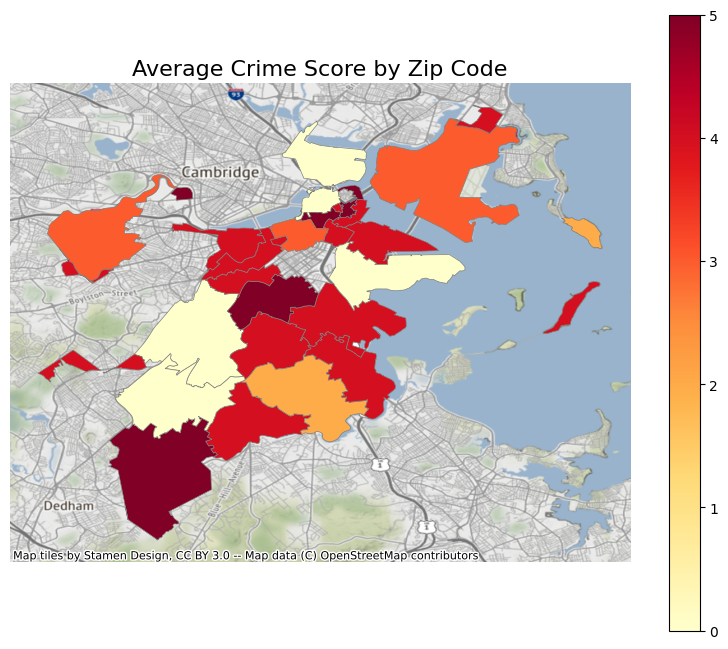

In [35]:
# Plotting the map of crime scores across city of Boston

fig, ax = plt.subplots(figsize=(10, 8))
crm_data.plot(column="crime_score", cmap="YlOrRd", linewidth=0.5, edgecolor="gray", legend=True, ax=ax)
ax.axis("off")
ax.set_title("Average Crime Score by Zip Code", fontsize=16)
ctx.add_basemap(ax, crs = crm_data.crs)

plt.show()



### 4. Housing data

The housing data was initially planned to be obtained from Zillow; however, due to limited data availability for Boston, I consulted with Justina and decided to use rental data from Jeff Kaufman. The compiled data lists apartment rentals from January to April of 2023, and can be found at the following link: https://www.jefftk.com/apartment_prices/data-listing.

To process the data, I used a script to read in the data from the URL and assigned column names to the resulting table. I then combined the data from all four months into a single dataframe for further analysis.

### 4.1 Reading the Boston Apartment rent data

In [36]:
import pandas as pd
#reading all the 2023 apartment data
df_04_23 = pd.read_csv("https://www.jefftk.com/apartment_prices/apts-1681830612.txt", header=None, delim_whitespace=True)
df_03_23 = pd.read_csv("https://www.jefftk.com/apartment_prices/apts-1679147875.txt", header=None, delim_whitespace=True)
df_02_23 = pd.read_csv("https://www.jefftk.com/apartment_prices/apts-1677031635.txt", header=None, delim_whitespace=True)
df_01_23 = pd.read_csv("https://www.jefftk.com/apartment_prices/apts-1674064961.txt", header=None, delim_whitespace=True)


##### Renaming all the columns of the dataframes 

In [37]:
df_04_23.columns = ["rent_price", "number_of_bedrooms", "id", "long", "lat"]
df_03_23.columns = ["rent_price", "number_of_bedrooms", "id", "long", "lat"]
df_02_23.columns = ["rent_price", "number_of_bedrooms", "id", "long", "lat"]
df_01_23.columns = ["rent_price", "number_of_bedrooms", "id", "long", "lat"]


In [38]:
df_01_23.head(4)

rent_price  number_of_bedrooms        id       long        lat
0        1000                   1  52094512 -71.146838  42.296143
1        2530                   0  48845076 -71.169186  42.266850
2        2350                   1  30003437 -71.156407  42.264671
3        2605                   2  30003438 -71.156407  42.264671

##### Merging all the 4 months of data into one dataframe

In [39]:
apt_concat = pd.concat([df_04_23, df_03_23, df_02_23, df_01_23], axis=0, ignore_index=True)


In [40]:
apt_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18529 entries, 0 to 18528
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rent_price          18529 non-null  int64  
 1   number_of_bedrooms  18529 non-null  int64  
 2   id                  18529 non-null  int64  
 3   long                18529 non-null  float64
 4   lat                 18529 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 723.9 KB


Performing a spatial join between the rental apartment dataframe and our ZCTA df stored in zipcodes.

In [41]:
# Convert the apartments data frame to a GeoDataFrame
apts_gdf = gpd.GeoDataFrame(
    apt_concat, geometry=gpd.points_from_xy(apt_concat.long, apt_concat.lat)
)

# Perform the spatial join between the apartments rental data and zipcodes geodataframes
merged_apt = gpd.sjoin(apts_gdf, zipcodes, how='left', op='within')


/Users/elizavardanyan/mambaforge/envs/geo/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/s1/534byrbj2dzd4fltzk4wf9cc0000gn/T/ipykernel_12325/2867440339.py:7: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  merged_apt = gpd.sjoin(apts_gdf, zipcodes, how='left', op='within')


In [42]:
merged_apt.head(3)

rent_price  number_of_bedrooms        id       long        lat  \
0        2495                   0  48845078 -71.171305  42.267408   
1        2365                   1  48845076 -71.171305  42.267408   
2        2205                   2  45649355 -71.158200  42.260600   

                     geometry  index_right  OBJECTID    ZIP5   ShapeSTArea  \
0  POINT (-71.17131 42.26741)         17.0      18.0  2132.0  1.293607e+08   
1  POINT (-71.17131 42.26741)         17.0      18.0  2132.0  1.293607e+08   
2  POINT (-71.15820 42.26060)         17.0      18.0  2132.0  1.293607e+08   

   ShapeSTLength  
0    68024.57171  
1    68024.57171  
2    68024.57171

### 4.2 Reclassifying apartment rental data

To reclassify the rental data, I created bins for the rent prices, number of bedrooms, latitude, and longitude columns. Based on the bin that each indicator falls into, scores were assigned accordingly. Note that in the case of rent prices, the labels or scores assigned are in descending order. This is because higher prices are less preferable. With the number of bedrooms, the more bedrooms there are, the higher the score assigned.

In [43]:
# create bins and labels for rent prices, number of bedrooms, and location scores
rent_price_bins = [0, 1500, 2000, 2500, 3000, merged_apt['rent_price'].max()]
rent_price_labels = [5, 4, 3, 2, 1]
bedroom_bins = [-1, 0, 1, 2, 3, merged_apt['number_of_bedrooms'].max()]
bedroom_labels = [1, 2, 3, 4, 5]


Below, I first identified the mean latitude and longitude values for the downtown area of Boston. Then, I created bins and labels for the latitude and longitude so that depending on how close the location of a rental is to those bins, the corresponding score would be assigned to it. For example, if the latitude and longitude of a data point fall within the first bin for latitude and the second bin for longitude, the corresponding label would be (1, 2). Finally, I saved each of these scores into separate columns called lat_score and lon_score.

In [44]:
# Calculate mean latitude and longitude of Boston's downtown area
downtown_lat = 42.355602
downtown_lon = -71.0636

# Create bins and labels for latitude and longitude
lat_bins = [merged_apt['lat'].min(), downtown_lat - 0.005, downtown_lat, downtown_lat + 0.005, merged_apt['lat'].max()]
lat_labels = [1, 2, 3, 4]

lon_bins = [merged_apt['long'].min(), downtown_lon - 0.005, downtown_lon, downtown_lon + 0.005, merged_apt['long'].max()]
lon_labels = [1, 2, 3, 4]


In [45]:
# create new columns with location scores
merged_apt['lat_score'] = pd.cut(merged_apt['lat'], bins=lat_bins, labels=lat_labels)
merged_apt['lon_score'] = pd.cut(merged_apt['long'], bins=lon_bins, labels=lon_labels)

# replace NaN values in lat_score and lon_score columns with a new category
merged_apt['lat_score'] = merged_apt['lat_score'].cat.add_categories([-1]).fillna(-1)
merged_apt['lon_score'] = merged_apt['lon_score'].cat.add_categories([-1]).fillna(-1)

# convert columns to integers
merged_apt['lat_score'] = merged_apt['lat_score'].astype(int)
merged_apt['lon_score'] = merged_apt['lon_score'].astype(int)

# 

Saving the rent price score and the score for the number of bedrooms in two separate columns, named rent_price_score and bedroom_score respectively. 

In [46]:
# create new columns with rent price, number of bedroom, and location scores

merged_apt['rent_price_score'] = pd.cut(merged_apt['rent_price'], bins=rent_price_bins, labels=rent_price_labels)
merged_apt['bedroom_score'] = pd.cut(merged_apt['number_of_bedrooms'], bins=bedroom_bins, labels=bedroom_labels)


In [47]:
merged_apt.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 18529 entries, 0 to 18528
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   rent_price          18529 non-null  int64   
 1   number_of_bedrooms  18529 non-null  int64   
 2   id                  18529 non-null  int64   
 3   long                18529 non-null  float64 
 4   lat                 18529 non-null  float64 
 5   geometry            18529 non-null  geometry
 6   index_right         11692 non-null  float64 
 7   OBJECTID            11692 non-null  float64 
 8   ZIP5                11692 non-null  float64 
 9   ShapeSTArea         11692 non-null  float64 
 10  ShapeSTLength       11692 non-null  float64 
 11  lat_score           18529 non-null  int64   
 12  lon_score           18529 non-null  int64   
 13  rent_price_score    18529 non-null  category
 14  bedroom_score       18529 non-null  category
dtypes: category(2), float64(7), 

To classify the rental data, I created bins for rent prices, number of bedrooms, and latitude/longitude columns. I then assigned scores based on the bin that each indicator fell into. For rent prices, higher prices were assigned lower scores, while for the number of bedrooms, a higher score was assigned for more bedrooms.

To assess the suitability of each rental, I calculated an overall score by summing the four scores (rent price, bedroom count, latitude score, and longitude score) together. To calculate the latitude and longitude scores, I first determined the mean latitude and longitude values for downtown Boston. I then created bins and labels for each, based on their proximity to downtown. The closer a rental was to downtown, the higher its corresponding latitude and longitude scores.

I made sure to convert each score to a float or integer, as appropriate, and saved the overall score in a new column called 'overall_score' within the same dataframe. This final score will be used to conduct the suitability analysis.

In [48]:
merged_apt['rent_price_score'] = merged_apt['rent_price_score'].astype(float)
merged_apt['bedroom_score'] = merged_apt['bedroom_score'].astype(float)
merged_apt['overall_score'] = merged_apt['rent_price_score'] + merged_apt['bedroom_score'] + merged_apt['lat_score'] + merged_apt['lon_score']

In [49]:
merged_apt.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 18529 entries, 0 to 18528
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   rent_price          18529 non-null  int64   
 1   number_of_bedrooms  18529 non-null  int64   
 2   id                  18529 non-null  int64   
 3   long                18529 non-null  float64 
 4   lat                 18529 non-null  float64 
 5   geometry            18529 non-null  geometry
 6   index_right         11692 non-null  float64 
 7   OBJECTID            11692 non-null  float64 
 8   ZIP5                11692 non-null  float64 
 9   ShapeSTArea         11692 non-null  float64 
 10  ShapeSTLength       11692 non-null  float64 
 11  lat_score           18529 non-null  int64   
 12  lon_score           18529 non-null  int64   
 13  rent_price_score    18529 non-null  float64 
 14  bedroom_score       18529 non-null  float64 
 15  overall_score       18529 no

In [50]:
merged_apt.head(4)

rent_price  number_of_bedrooms        id       long        lat  \
0        2495                   0  48845078 -71.171305  42.267408   
1        2365                   1  48845076 -71.171305  42.267408   
2        2205                   2  45649355 -71.158200  42.260600   
3        2900                   4  46221464 -71.137978  42.278121   

                     geometry  index_right  OBJECTID    ZIP5   ShapeSTArea  \
0  POINT (-71.17131 42.26741)         17.0      18.0  2132.0  1.293607e+08   
1  POINT (-71.17131 42.26741)         17.0      18.0  2132.0  1.293607e+08   
2  POINT (-71.15820 42.26060)         17.0      18.0  2132.0  1.293607e+08   
3  POINT (-71.13798 42.27812)         24.0      25.0  2131.0  8.168880e+07   

   ShapeSTLength  lat_score  lon_score  rent_price_score  bedroom_score  \
0   68024.571710          1          1               3.0            1.0   
1   68024.571710          1          1               3.0            2.0   
2   68024.571710          1          1               3.0            3.0   
3   68311.545122          1          1               2.0            5.0   

   overall_score  
0            6.0  
1            7.0  
2            8.0  
3            9.0

To calculate the mean of all scores per ZIP address, I created an aggregate function in a dictionary that maps input values to corresponding actions. After trying several aggregate functions, I chose to use the 'mean' function to calculate the mean score of the values. Next, I grouped all the data by ZIP code and returned the mean housing score per ZIP code.

In [51]:
import pandas as pd

# Define the aggregation functions
agg_functions = {
    'overall_score': 'mean'
    # 'id': 'count'
}

# Group by ZIP code and apply the aggregation functions
grouped = merged_apt.groupby('ZIP5').agg(agg_functions)

# Rename the 'id' column to 'count'
grouped = grouped.rename(columns={'id': 'count'})

# Reset the index to make ZIP5 a column again
grouped = grouped.reset_index()

# Print the result
print(grouped)


      ZIP5  overall_score
0   2108.0       9.766667
1   2109.0      11.008696
2   2110.0       9.740000
3   2111.0       8.384858
4   2113.0      12.489426
5   2114.0       9.546995
6   2115.0       6.261329
7   2116.0       6.527550
8   2118.0       6.175337
9   2119.0       7.323232
10  2120.0       7.016667
11  2121.0       7.897959
12  2122.0       9.727273
13  2124.0       7.810909
14  2125.0       9.253695
15  2126.0       7.659341
16  2127.0       9.321168
17  2128.0      12.797217
18  2129.0      10.353846
19  2130.0       6.967742
20  2131.0       6.985507
21  2132.0       6.912500
22  2134.0       7.874172
23  2135.0       7.292683
24  2136.0       7.692308
25  2199.0       4.545455
26  2203.0      11.000000
27  2210.0       8.480198
28  2215.0       6.188379
29  2467.0       6.142857


In [52]:
# note this code resclaes the score from 1 to 5
avg_score_apt = merged_apt.groupby("ZIP5")["overall_score"].mean()

# crm_data = zipcodes.merge(avg_scores, left_on="ZIP5", right_index=True)
avg_score_apt.head(4)


ZIP5
2108.0     9.766667
2109.0    11.008696
2110.0     9.740000
2111.0     8.384858
Name: overall_score, dtype: float64

Since my overall score was a sum of various indicators (number of bedrooms, rent price, latitude and longitude), it resulted in a score that could go as high as 12. To normalize this score with the rest of the indicators, I used a MinMax Scaler to rescale it to a range of 1 to 5. I also made sure to fill all the NaN values with 0.

### 4.3 Rescaling the rental apartment score

In [53]:
# since in this indicator's calculation we are summing up a fwe scores together, to ensure
scaler = MinMaxScaler(feature_range=(1,5))

# # fit the scaler on the overall_score column and transform it
grouped['rescaled_score'] = scaler.fit_transform(grouped[['overall_score']])
grouped['rescaled_score'] = grouped['rescaled_score'].fillna(0)


### 4.4 Visualizign the rental score by Zip Code

I merged the housing data with the geospatial data for the zipcodes and created a visualization using Matplotlib's colorplot function.

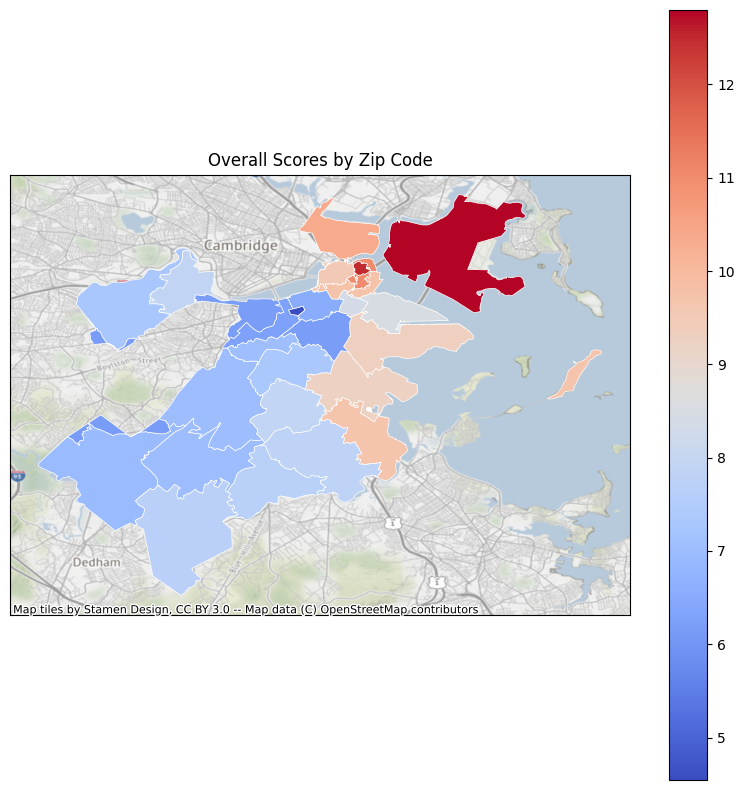

In [54]:

# Merge the data with the shapefile based on the ZIP code
merged_hs = zipcodes.merge(grouped, on='ZIP5')

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10,10))

# Plot the choropleth map
merged_hs.plot(column='overall_score', cmap='coolwarm', linewidth=0.5, ax=ax, edgecolor='white', legend=True)

# Add a title
ax.set_title('Overall Scores by Zip Code')

# Remove the axis ticks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ctx.add_basemap(ax, crs = merged_hs.crs,alpha =  0.7)



# Show the plot
plt.show()


### 5. Public Schools Data

The next indicator selected for analysis is public school data. Since education and access to good public schools are of high interest for a family of four moving to the City of Boston, analyzing the availability of public schools in the rental area is essential. To access this information, I used the Public Schools data provided by the City of Boston's Open Data Portal, which can be found here: https://data.boston.gov/dataset/public-schools. This data provides information on the school's address, name, school type, geolocation, and other relevant details.

### 5.1 Reading the public schools data

In [55]:
education_data = pd.read_csv('Public_Schools.csv')

In [56]:
education_data.head()

X             Y  BLDG_ID              BLDG_NAME  \
0  790128.152748  2.967094e+06        1             Guild Bldg   
1  783027.745829  2.963318e+06        3        Kennedy, P Bldg   
2  782112.823908  2.962122e+06        4              Otis Bldg   
3  780994.000003  2.963140e+06        6          Odonnell Bldg   
4  781823.000004  2.964190e+06        7  East Boston High Bldg   

               ADDRESS         CITY  ZIPCODE  CSP_SCH_ID  SCH_ID  \
0    195 Leyden Street  East Boston     2128        4061    4061   
1  343 Saratoga Street  East Boston     2128        4541    4541   
2    218 Marion Street  East Boston     2128        4322    4322   
3    33 Trenton Street  East Boston     2128        4543    4543   
4      86 White Street  East Boston     2128        1070    1070   

               SCH_NAME       SCH_LABEL SCH_TYPE SHARED COMPLEX  OBJECTID  
0      Guild Elementary           Guild       ES                        1  
1  Kennedy Patrick Elem      PJ Kennedy       ES                        2  
2       Otis Elementary            Otis       ES                        3  
3  O'Donnell Elementary       O'Donnell       ES                        4  
4      East Boston High  East Boston HS       HS                        5

In [57]:
len(education_data)

134

I convert my schools dataframe to a geospatial dataframe to be able to visualize it in the later stage.

In [58]:
# Load data
schools_df = pd.read_csv('Public_Schools.csv')

# Convert to GeoDataFrame and set the geometry column
schools_gdf = gpd.GeoDataFrame(schools_df, geometry=gpd.points_from_xy(schools_df['X'], schools_df['Y']))


I then re-read the ZCTA data in a geodataframe to use it with the schools geodataframe. I did this step again as I wanted to ensure that my ZCTA dataframe was intact in my further analysis. 

In [59]:
# Load ZIP code data
zip_codes_gdf = gpd.read_file('ZIP_Codes.geojson')


In [60]:
schools_gdf.columns

Index(['X', 'Y', 'BLDG_ID', 'BLDG_NAME', 'ADDRESS', 'CITY', 'ZIPCODE',
       'CSP_SCH_ID', 'SCH_ID', 'SCH_NAME', 'SCH_LABEL', 'SCH_TYPE', 'SHARED',
       'COMPLEX', 'OBJECTID', 'geometry'],
      dtype='object')

### 5.2 Reclassifying the public schools data

Since I was given the location of the schools, I wrote a for loop to find out the proximity of the schools to each other and assign scores based on this. The regions with more public school availability get higher scores.

In [61]:
zip_codes_gdf = zip_codes_gdf.set_geometry('geometry')
schools_gdf = schools_gdf.set_geometry('geometry')

# Assign scores based on proximity to schools
scores = []
for index, row in zip_codes_gdf.iterrows():
    # Calculate distance to nearest school
    distances = schools_gdf.geometry.distance(row.geometry)
    nearest_distance = distances.min()
    
    # Calculate score based on inverse distance
    if nearest_distance == 0:
        score = 10
    else:
        score = 1 / nearest_distance
    scores.append(score)

zip_codes_gdf['school_scores'] = scores

# Rescale scores to range of 1 to 10
min_score = zip_codes_gdf['school_scores'].min()
max_score = zip_codes_gdf['school_scores'].max()
rescaled_scores = (zip_codes_gdf['school_scores'] - min_score) / (max_score - min_score) * 9 + 1

zip_codes_gdf['rescaled_score'] = rescaled_scores


In [62]:
zip_codes_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   OBJECTID        43 non-null     int64   
 1   ZIP5            43 non-null     object  
 2   ShapeSTArea     43 non-null     float64 
 3   ShapeSTLength   43 non-null     float64 
 4   geometry        43 non-null     geometry
 5   school_scores   43 non-null     float64 
 6   rescaled_score  43 non-null     float64 
dtypes: float64(4), geometry(1), int64(1), object(1)
memory usage: 2.5+ KB


Since in the later stages I will need to merge my dataframe with other dataframes based on the Zip code, I change my ZIP code to a type int. 

In [63]:
zip_codes_gdf['ZIP5'] = zip_codes_gdf['ZIP5'].astype(int)

In [64]:
print(schools_gdf.columns)

Index(['X', 'Y', 'BLDG_ID', 'BLDG_NAME', 'ADDRESS', 'CITY', 'ZIPCODE',
       'CSP_SCH_ID', 'SCH_ID', 'SCH_NAME', 'SCH_LABEL', 'SCH_TYPE', 'SHARED',
       'COMPLEX', 'OBJECTID', 'geometry'],
      dtype='object')


In [65]:
zip_codes_gdf.head(3)

OBJECTID  ZIP5   ShapeSTArea  ShapeSTLength  \
0         1  2134  3.721936e+07   40794.182396   
1         2  2125  6.476052e+07   62224.521440   
2         3  2110  6.637284e+06   18358.213496   

                                            geometry  school_scores  \
0  POLYGON ((-71.12340 42.36421, -71.12345 42.364...   3.325655e-07   
1  POLYGON ((-71.04541 42.32381, -71.04579 42.323...   3.325655e-07   
2  POLYGON ((-71.05109 42.36418, -71.05109 42.364...   3.325655e-07   

   rescaled_score  
0        7.313522  
1        6.224510  
2        7.829844

I merge  the school data with the ZCTA geodataframe based on the common column of Zip Code that these dataframes share. 

I then aggregate all the school scores by ZIP code of those schools and find the mean of the scores as well as the count of the schools in that zip code region. 

In [66]:
zip_codes_gdf.head(4)

OBJECTID  ZIP5   ShapeSTArea  ShapeSTLength  \
0         1  2134  3.721936e+07   40794.182396   
1         2  2125  6.476052e+07   62224.521440   
2         3  2110  6.637284e+06   18358.213496   
3         4  2118  3.116158e+07   32353.407618   

                                            geometry  school_scores  \
0  POLYGON ((-71.12340 42.36421, -71.12345 42.364...   3.325655e-07   
1  POLYGON ((-71.04541 42.32381, -71.04579 42.323...   3.325655e-07   
2  POLYGON ((-71.05109 42.36418, -71.05109 42.364...   3.325655e-07   
3  POLYGON ((-71.06315 42.34689, -71.06433 42.347...   3.325655e-07   

   rescaled_score  
0        7.313522  
1        6.224510  
2        7.829844  
3        6.917153

I then merge this data with the zipcodes geodatframe as I lost my geodata information by aggregating it by Zip code. Now that I have the ZCTA data merged with the schools data, I can visualize this data.

In [67]:
# Convert the resulting DataFrame to a GeoDataFrame
schools_gpd = gpd.GeoDataFrame(zip_codes_gdf, geometry='geometry')

In [68]:
schools_gpd.head(4)

OBJECTID  ZIP5   ShapeSTArea  ShapeSTLength  \
0         1  2134  3.721936e+07   40794.182396   
1         2  2125  6.476052e+07   62224.521440   
2         3  2110  6.637284e+06   18358.213496   
3         4  2118  3.116158e+07   32353.407618   

                                            geometry  school_scores  \
0  POLYGON ((-71.12340 42.36421, -71.12345 42.364...   3.325655e-07   
1  POLYGON ((-71.04541 42.32381, -71.04579 42.323...   3.325655e-07   
2  POLYGON ((-71.05109 42.36418, -71.05109 42.364...   3.325655e-07   
3  POLYGON ((-71.06315 42.34689, -71.06433 42.347...   3.325655e-07   

   rescaled_score  
0        7.313522  
1        6.224510  
2        7.829844  
3        6.917153

I filled all the potential NaN values for the schools scores with 0. This ensures us that there is no NaN in the later calculation stages. 

In [69]:
#ensure na values are 0
schools_gpd['rescaled_score'] = schools_gpd['rescaled_score'].fillna(0)


### 5.3 Visualizing the public schools data

I then create a coloroplot based on the school scores of a region and map it out with darker shades corresponding to the higher scores and lighter areas to the lower scores. 

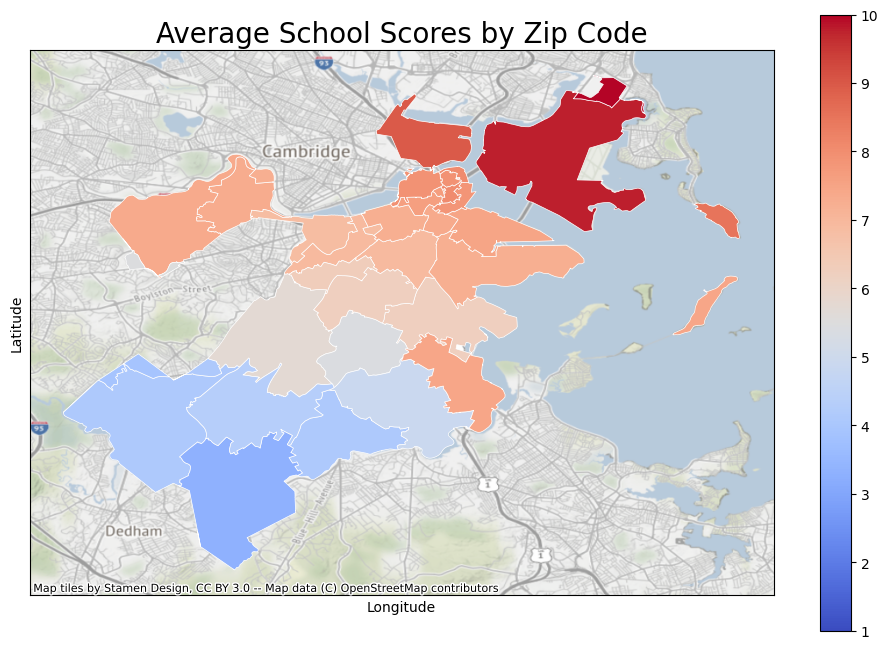

In [70]:
# Create the color plot
fig, ax = plt.subplots(figsize=(12, 8))

schools_gpd.plot(column='rescaled_score',linewidth=0.5, cmap='coolwarm', ax=ax, edgecolor = 'white', legend=True)

# Set plot title and labels
ax.set_title('Average School Scores by Zip Code', fontsize=20)
ax.set_xlabel('Longitude', fontsize=10)
ax.set_ylabel('Latitude', fontsize=10)

# Remove the axis ticks and add a basemap with white color
ax.set_xticks([])
ax.set_yticks([])
# ctx.add_basemap(ax, alpha=0.5, facecolor='white', crs = schools_gpd.crs)
ctx.add_basemap(ax, crs = schools_gpd.crs, alpha =  0.7)


# Show the plot
plt.show()


## 6. Final data cleaning and merge of all the dataframes

As there were some columns in my dataframes that I did not require, I opted to remove them and retain only the necessary ones. Therefore, I kept only the columns that contained the scores for each indicator, the ZIP code, and the geometry column.

##### Cleaning the schools dataframe

In [71]:
## schools
sch_df = schools_gpd.loc[:, ['rescaled_score', 'ZIP5']]
sch_df = sch_df.rename(columns={"rescaled_score": "school_score"})
sch_df['school_score'] = sch_df['school_score'].fillna(0)


sch_df.head(4)

school_score  ZIP5
0      7.313522  2134
1      6.224510  2125
2      7.829844  2110
3      6.917153  2118

##### Cleaning the hospitals dataframe

In [72]:
## hospitals 
data_zip_hospital.head(4)
hospital_df = data_zip_hospital.loc[:, ['total_score', 'ZIP5']]
# hospital_df.head(4)
hospital_df = hospital_df.rename(columns={"total_score": "hospital_score"})
hospital_df['hospital_score'] = hospital_df['hospital_score'].fillna(0)
hospital_df.head(4)

hospital_score  ZIP5
0             1.0  2134
1             1.0  2125
2             0.0  2110
3             1.5  2118

##### Cleaning the Crime dataframe

In [73]:
## crime
crm_data.head(4)
crime_df = crm_data.loc[:, ['crime_score', 'ZIP5']]
crime_df['crime_score'] = crime_df['crime_score'].fillna(0)
crime_df.head(4)

crime_score  ZIP5
1            4  2125
2            4  2110
4            4  2126
5            5  2109

##### Cleaning the housing dataframe

In [74]:
## housing 
merged_hs.head(4)



OBJECTID  ZIP5   ShapeSTArea  ShapeSTLength  \
0         1  2134  3.721936e+07   40794.182396   
1         2  2125  6.476052e+07   62224.521440   
2         3  2110  6.637284e+06   18358.213496   
3         4  2118  3.116158e+07   32353.407618   

                                            geometry  overall_score  \
0  POLYGON ((-71.12340 42.36421, -71.12345 42.364...       7.874172   
1  POLYGON ((-71.04541 42.32381, -71.04579 42.323...       9.253695   
2  POLYGON ((-71.05109 42.36418, -71.05109 42.364...       9.740000   
3  POLYGON ((-71.06315 42.34689, -71.06433 42.347...       6.175337   

   rescaled_score  
0        2.613579  
1        3.282296  
2        3.518030  
3        1.790077

In [75]:
# merged.columns
house_df = merged_hs.loc[:, ['rescaled_score', 'ZIP5']]
house_df = house_df.rename(columns={"rescaled_score": "rent_score"})
house_df['rent_score'] = house_df['rent_score'].fillna(0)
house_df.head(4)

rent_score  ZIP5
0    2.613579  2134
1    3.282296  2125
2    3.518030  2110
3    1.790077  2118

In [76]:
# rent_nan_values= house_df.isna().any(axis=1)
# rent_nan_df = house_df[rent_nan_values]
# rent_nan_df

##### After cleaning the datafrmaes of unused columns, I merge all of the indicators' dataframes based on the ZIP code they share. 

In [77]:
# Merge the dataframes on the ZIP5 column
risk_df = pd.merge(hospital_df, house_df, on='ZIP5', how = 'left')
risk_df = pd.merge(risk_df, sch_df, on='ZIP5', how = 'left')
risk_df = pd.merge(risk_df, crime_df, on='ZIP5', how = 'left')
risk_df['rent_score'] = risk_df['rent_score'].fillna(0)
risk_df['crime_score'] = risk_df['crime_score'].fillna(0)
risk_df['hospital_score'] = risk_df['hospital_score'].fillna(0)
risk_df['school_score'] = risk_df['school_score'].fillna(0)

risk_df.head(4)

hospital_score  ZIP5  rent_score  school_score  crime_score
0             1.0  2134    2.613579      7.313522          0.0
1             1.0  2125    3.282296      6.224510          4.0
2             0.0  2110    3.518030      7.829844          4.0
3             1.5  2118    1.790077      6.917153          0.0

##### I clean up the resulting dataframe and only keep the columns that I need.

In [78]:
risk_df = risk_df.loc[:, ['crime_score', 'rent_score', 'hospital_score', 'school_score','ZIP5']]


###  6.2 Weighted sutiability score calculation:

For the suitability analysis of the family of four moving to Boston with children, I have assigned the following weights to the four indicators:

- Housing rental price (35%): Boston is an expensive city to live in, and affordability is often a critical factor for families searching for rental apartments. Therefore, the rental price of a housing unit should be given a relatively higher weight compared to other factors.
- Access to public schools (30%): Given that the family has two kids, public schools are an important consideration for them. In addition to the quality of schools, access to them is also important. Therefore, this factor should be given a relatively high weight in the analysis.
- Hospital proximity and quality (20%): While being close to a quality hospital is very important, given that the family has a mode of transportation, the proximity is not given as high of a weight as the two indicators mentioned above. Therefore, this factor should be given a relatively lower weight compared to the above two factors.
- Crime (15%): While safety is of utmost importance for a family of four moving to Boston, however, Boston is a relatively safer city, and this score may not be as critical as the rest of the indicators, as the overall score across the city should be relatively low.

After assigning the weights, we find the total weighted score for the suitability index.

In [79]:
risk_df['weighted_score'] = (
    (risk_df['rent_score'].fillna(0) * 0.35) +  #this is the housing score 
    (risk_df['school_score'].fillna(0) * 0.30) + #school score 
    (risk_df['hospital_score'].fillna(0) * 0.2) +   # this is hospital score
    (risk_df['crime_score'].fillna(0) * 0.15)     #crime score
)


risk_df.head(3)


crime_score  rent_score  hospital_score  school_score  ZIP5  weighted_score
0          0.0    2.613579             1.0      7.313522  2134        3.308809
1          4.0    3.282296             1.0      6.224510  2125        3.816157
2          4.0    3.518030             0.0      7.829844  2110        4.180264

In [80]:
# nan_rows = risk_df.isna().any(axis=1)
# nan_df = risk_df[nan_rows]
# nan_df


We also sum up all the unweightes scores together to find out the final suitability score.

In [81]:
risk_df.head(4)

crime_score  rent_score  hospital_score  school_score  ZIP5  weighted_score
0          0.0    2.613579             1.0      7.313522  2134        3.308809
1          4.0    3.282296             1.0      6.224510  2125        3.816157
2          4.0    3.518030             0.0      7.829844  2110        4.180264
3          0.0    1.790077             1.5      6.917153  2118        3.001673

Finally, we convert our dataframe of all the scores into a geodataframe and merge it with the ZCTA data.

In [82]:
map_df = gpd.read_file('ZIP_Codes.geojson') #zipcodes 
risk_df["ZIP5"] = risk_df["ZIP5"].astype(int)
map_df['ZIP5'] = map_df['ZIP5'].astype(int)
map_df = map_df.merge(risk_df, on='ZIP5')

In [83]:
map_df.head(4)

OBJECTID  ZIP5   ShapeSTArea  ShapeSTLength  \
0         1  2134  3.721936e+07   40794.182396   
1         2  2125  6.476052e+07   62224.521440   
2         3  2110  6.637284e+06   18358.213496   
3         4  2118  3.116158e+07   32353.407618   

                                            geometry  crime_score  rent_score  \
0  POLYGON ((-71.12340 42.36421, -71.12345 42.364...          0.0    2.613579   
1  POLYGON ((-71.04541 42.32381, -71.04579 42.323...          4.0    3.282296   
2  POLYGON ((-71.05109 42.36418, -71.05109 42.364...          4.0    3.518030   
3  POLYGON ((-71.06315 42.34689, -71.06433 42.347...          0.0    1.790077   

   hospital_score  school_score  weighted_score  
0             1.0      7.313522        3.308809  
1             1.0      6.224510        3.816157  
2             0.0      7.829844        4.180264  
3             1.5      6.917153        3.001673

In [84]:
nan_geometry = map_df.isna().any()
nan_geometry

OBJECTID          False
ZIP5              False
ShapeSTArea       False
ShapeSTLength     False
geometry          False
crime_score       False
rent_score        False
hospital_score    False
school_score      False
weighted_score    False
dtype: bool

Visualize the weightes suitability score across Boston, where darker shades mean a higher preference/suitable area to look into, and lighter shades mean a less suitable area to look into. 

### 6.3 Visualizing the weighted suitability score by Zip Code

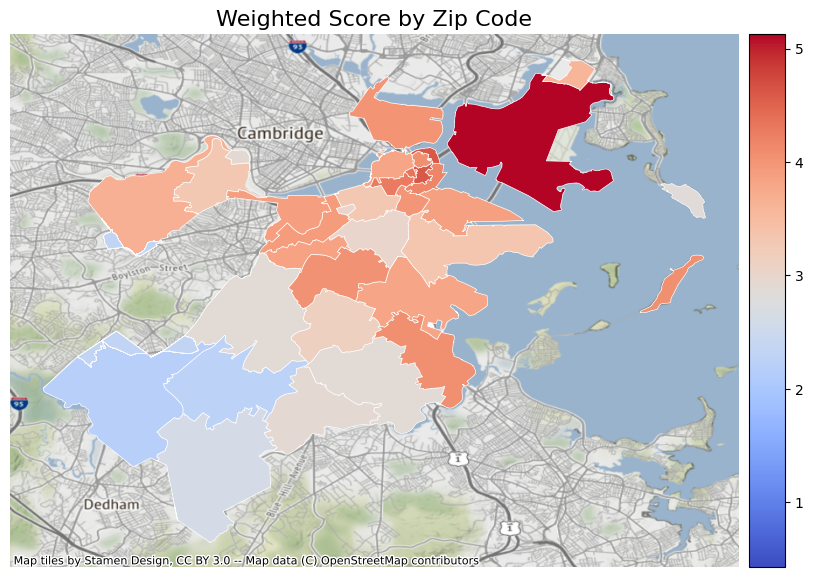

In [85]:
#weighted score plot

map_df = map_df.set_geometry('geometry')
fig, ax = plt.subplots(figsize=(10, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
map_df.plot(column='weighted_score', cmap='coolwarm', linewidth=0.5, ax=ax, edgecolor='white', legend=True, cax=cax)
ax.axis('off')
ax.set_title('Weighted Score by Zip Code', fontsize=16)
ctx.add_basemap(ax, crs = map_df.crs)


plt.show()

### 6.4 Unweighted suitability score calculation

In [86]:
risk_df['unweighted_score'] = (
    (risk_df['rent_score']).fillna(0) +  #this is the housing score 
    (risk_df['school_score']).fillna(0) + #school score 
    (risk_df['hospital_score']).fillna(0) +  #hospital score
    (risk_df['crime_score'] ).fillna(0)   #crime score
)
# create an instance of MinMaxScaler
scaler = MinMaxScaler(feature_range=(1,5))

# fit the scaler on the overall_score column and transform it
risk_df['unweighted_score'] = scaler.fit_transform(risk_df[['unweighted_score']])

risk_df['unweighted_score'] = risk_df['unweighted_score'].fillna(0)

map_df = gpd.read_file('ZIP_Codes.geojson') #zipcodes 
risk_df["ZIP5"] = risk_df["ZIP5"].astype(int)
map_df['ZIP5'] = map_df['ZIP5'].astype(int)
map_df = map_df.merge(risk_df, on='ZIP5')

map_df['unweighted_score'] = map_df['unweighted_score'].fillna(0)




### 6.5 Visualizing the unweightes suitability score

Visualize the unweighted suitability score across Boston, where darker shades mean a higher preference/suitable area to look into, and lighter shades mean a less suitable area to look into. 

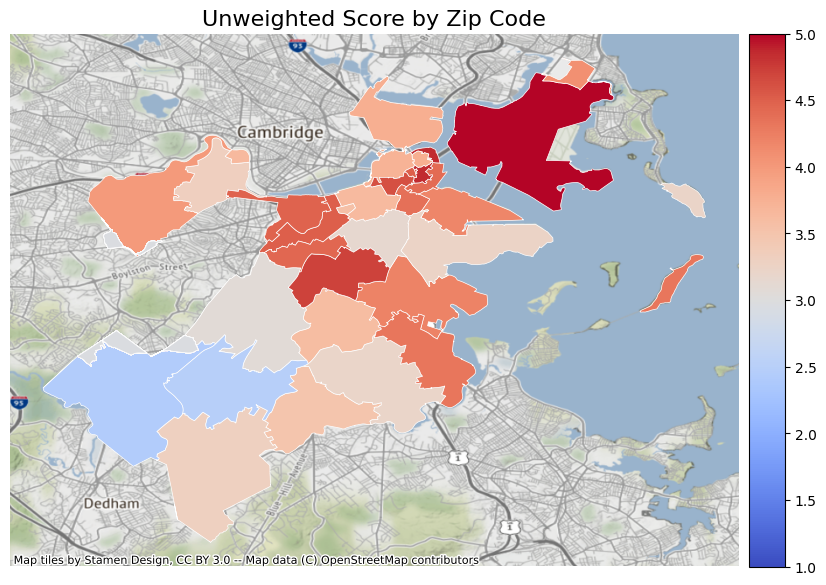

In [87]:
#unweighted score plot 
fig, ax = plt.subplots(figsize=(10, 10))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

map_df.plot(column='unweighted_score', cmap='coolwarm', linewidth=0.5, ax=ax, edgecolor='white', legend=True, cax=cax)

ax.axis('off')
ax.set_title('Unweighted Score by Zip Code', fontsize=16)
ctx.add_basemap(ax, crs = map_df.crs)
plt.show()

In [88]:
map_df_gpd = gpd.GeoDataFrame(map_df, geometry='geometry', crs='EPSG:4326')
map_df_gpd.head()
# zip_codes


OBJECTID  ZIP5   ShapeSTArea  ShapeSTLength  \
0         1  2134  3.721936e+07   40794.182396   
1         2  2125  6.476052e+07   62224.521440   
2         3  2110  6.637284e+06   18358.213496   
3         4  2118  3.116158e+07   32353.407618   
4         5  2126  6.078585e+07   45488.394711   

                                            geometry  crime_score  rent_score  \
0  POLYGON ((-71.12340 42.36421, -71.12345 42.364...          0.0    2.613579   
1  POLYGON ((-71.04541 42.32381, -71.04579 42.323...          4.0    3.282296   
2  POLYGON ((-71.05109 42.36418, -71.05109 42.364...          4.0    3.518030   
3  POLYGON ((-71.06315 42.34689, -71.06433 42.347...          0.0    1.790077   
4  POLYGON ((-71.09670 42.29095, -71.09692 42.290...          4.0    2.509441   

   hospital_score  school_score  weighted_score  unweighted_score  
0             1.0      7.313522        3.308809          3.326213  
1             1.0      6.224510        3.816157          4.203166  
2             0.0      7.829844        4.180264          4.409210  
3             1.5      6.917153        3.001673          3.149859  
4             1.0      4.122818        2.915150          3.498961

### 7. Conclusion -Top Scores & Bottom scores
After analyzing the weighted scores, the colorplot revealed that the areas with the highest scores are primarily located in East Boston. This location boasts various amenities, including proximity to downtown Boston, public transportation, waterfront location, and affordable rent prices, making it an ideal location for a family of four in search of a rental apartment.

The zip codes with the highest scores in the four indicators analyzed are 2128, 2109, 2203, 2108, and 2110, which are primarily located in East Boston, Central Boston, and Back Bay/Beacon Hill. These areas offer a range of public amenities, including good schools and parks, along with proximity to major job centers, low crime rates, a strong sense of community, diverse population, and access to cultural and recreational opportunities, as well as high-quality healthcare and other essential services.

In addition to the selected indicators, the prime location of these areas is also due to their accessibility to public transportation and other qualifications. Therefore, these areas are the best options for a family of four in search of an apartment in Boston.


In [89]:
# Sort the DataFrame by the values in the 'column_name' column
map_df = map_df.sort_values('weighted_score', ascending=False)
# The top ZCTA's by the suitability score
print(map_df.head(5))


    OBJECTID  ZIP5   ShapeSTArea  ShapeSTLength  \
31        31  2128  1.478022e+08   82747.690323   
5          6  2109  5.536731e+06   22538.305842   
28        28  2203  8.644668e+05    4052.846084   
20        20  2108  6.162153e+06   18485.040129   
2          3  2110  6.637284e+06   18358.213496   

                                             geometry  crime_score  \
31  POLYGON ((-71.00402 42.39260, -71.00438 42.392...          3.0   
5   POLYGON ((-71.05781 42.35679, -71.05771 42.356...          5.0   
28  POLYGON ((-71.05817 42.36228, -71.05835 42.362...          4.0   
20  MULTIPOLYGON (((-71.05928 42.35923, -71.05950 ...          5.0   
2   POLYGON ((-71.05109 42.36418, -71.05109 42.364...          4.0   

    rent_score  hospital_score  school_score  weighted_score  unweighted_score  
31    5.000000             0.0      9.759465        5.127839          5.000000  
5     4.133023             0.0      8.034291        4.606845          4.854935  
28    4.128808             0.

The zip codes that received lower scores, namely 02026, 02186, 02459, 02021, 02132, are primarily located in Dedham, Milton, Newton, Canton, and West Roxbury. While these areas may have their advantages, they received lower scores due to several factors. For instance, the cost of living in some of these areas might be higher than what the family can afford. Moreover, the distance from downtown Boston might be farther than what the family is willing to commute. Additionally, some of these neighborhoods may have lower-rated schools or fewer parks and recreational opportunities, which might not be desirable for a family with children.

Ultimately, the suitability of a neighborhood for a family of four will depend on their specific needs, preferences, and priorities. Therefore, it is crucial for the family to carefully consider these factors before deciding where to live. Indicators such as driving distance or affordability of a housing unit are some of the factors that the family of four should consider before making a decision. Therefore, these indicators are helpful and accurate in their suitability analysis, considering the family's preferences and priorities.

In [90]:
# Sort the DataFrame by the values in the 'column_name' column
map_df = map_df.sort_values('weighted_score', ascending=True)
# The top ZCTA's by the suitability score
print(map_df.head(5))

    OBJECTID  ZIP5   ShapeSTArea  ShapeSTLength  \
35        35  2026  1.917403e+04    4025.190772   
34        34  2186  9.952196e+01      96.867245   
16        16  2459  2.483276e+04    9295.150639   
6          7  2021  2.361905e+03     432.194702   
18        18  2132  1.293607e+08   68024.571710   

                                             geometry  crime_score  \
35  POLYGON ((-71.14268 42.23601, -71.14275 42.236...          0.0   
34  POLYGON ((-71.11327 42.25893, -71.11328 42.258...          0.0   
16  POLYGON ((-71.19093 42.28324, -71.19090 42.283...          0.0   
6   POLYGON ((-71.13081 42.22789, -71.13082 42.227...          5.0   
18  POLYGON ((-71.13358 42.30001, -71.13394 42.300...          0.0   

    rent_score  hospital_score  school_score  weighted_score  unweighted_score  
35    0.000000             0.0      1.431553        0.429466          1.000000  
34    0.000000             0.0      2.534189        0.760257          1.270123  
16    0.000000             0.